In [1]:
%matplotlib inline

In [2]:
!pip install monai
!pip install lightning
!pip install nibabel
!pip install scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.6 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 56.6 MB/s eta 0:00:00:00:01


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pytorch_lightning as pl 
import os 
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity
from pathlib import Path
import torch 
import nibabel as nib
import torch.nn.functional as F
import torch.nn as nn
from monai.networks.nets import UNet
# Structural Similarity Loss
from monai.losses import SSIMLoss
from monai.networks.layers import Norm
from monai.data import CacheDataset, Dataset, DataLoader, list_data_collate, NibabelReader
from monai.transforms import (
    NormalizeIntensity,
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    Orientationd,
    SpatialCropd,
    MapTransform,
    SignalFillEmptyd,
    RandSpatialCropd
)
from monai.apps.reconstruction.transforms.dictionary import ReferenceBasedNormalizeIntensityd


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

DATA_DIR = Path('/kaggle/input/patch-the-planet')
TARGET_DATA_DIR = DATA_DIR / 'generated_part1_nii'
GEN_DATA_DIR = DATA_DIR / 'generated_part1_missing_nii'

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-02-22 19:05:39.464534: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-22 19:05:39.464640: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-22 19:05:39.593032: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
os.listdir(GEN_DATA_DIR)

['seismicCubes_RFC_fullstack_2023.76346660.nii',
 'seismicCubes_RFC_fullstack_2023.76347256.nii',
 'seismicCubes_RFC_fullstack_2023.76346755.nii',
 'seismicCubes_RFC_fullstack_2023.76346555.nii',
 'seismicCubes_RFC_fullstack_2023.76347251.nii',
 'seismicCubes_RFC_fullstack_2023.76346655.nii',
 'seismicCubes_RFC_fullstack_2023.76347250.nii',
 'seismicCubes_RFC_fullstack_2023.76347055.nii',
 'seismicCubes_RFC_fullstack_2023.76347351.nii',
 'seismicCubes_RFC_fullstack_2023.76347061.nii',
 'seismicCubes_RFC_fullstack_2023.76347454.nii',
 'seismicCubes_RFC_fullstack_2023.76347248.nii',
 'seismicCubes_RFC_fullstack_2023.76347020.nii',
 'seismicCubes_RFC_fullstack_2023.76346988.nii',
 'seismicCubes_RFC_fullstack_2023.76346757.nii',
 'seismicCubes_RFC_fullstack_2023.76346659.nii',
 'seismicCubes_RFC_fullstack_2023.76346962.nii',
 'seismicCubes_RFC_fullstack_2023.76346557.nii',
 'seismicCubes_RFC_fullstack_2023.76346759.nii',
 'seismicCubes_RFC_fullstack_2023.76347258.nii',
 'seismicCubes_RFC_f

In [5]:
assert sorted(os.listdir(GEN_DATA_DIR)) == sorted(os.listdir(TARGET_DATA_DIR))

In [6]:
DIMS = ['x', 'y', 'z']

def visualize_slices(nib_img, x, y, z, title):
    plt.figure(figsize=(12, 4), constrained_layout=True)
    plt.suptitle(title)
    slices = [np.s_[x, :, :], np.s_[:, y, :], np.s_[:, :, z]]
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(nib_img.get_fdata()[slices[i]], cmap='Greys')
        plt.title(f'Slice along {DIMS[i]}')

def rescale_volume(seismic):
    minval = np.percentile(seismic, 2)
    maxval = np.percentile(seismic, 98)
    seismic = np.clip(seismic, minval, maxval)
    seismic = ((seismic - minval) / (maxval - minval)) * 255
    
    return seismic

class RescaleTransform(MapTransform):
    def __call__(self, data):
        for key in self.keys:
            if key in data:
                # update output data with some_transform_function(data[key]).
                data[key] = rescale_volume(data[key])
        return data
    

class MaskTransform(MapTransform):
    
    def __call__(self, data):
        if 'image' in data:
            data['mask'] = torch.isnan(data['image'])
        return data                 

#### How original and training images differ

Original and corrupted images have different intensities because the later is scaled to some range - thus the same scaling will be applied to the original image

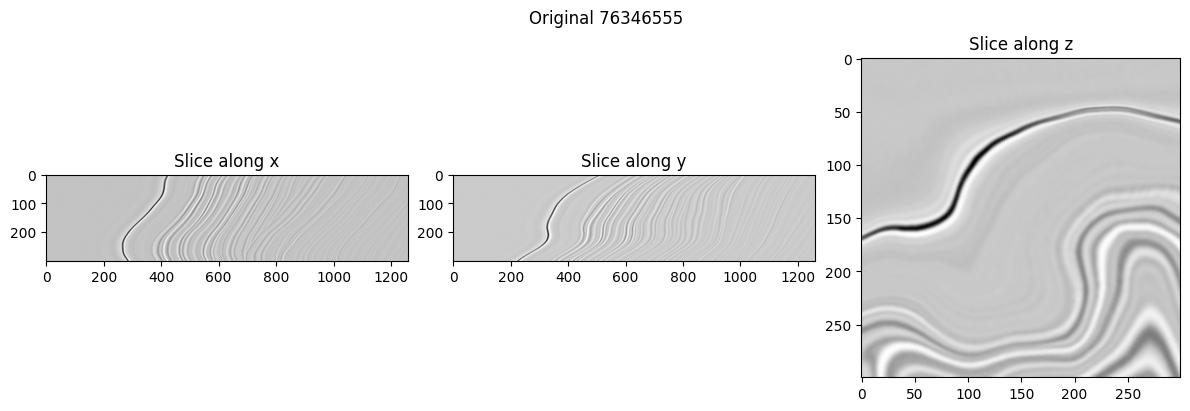

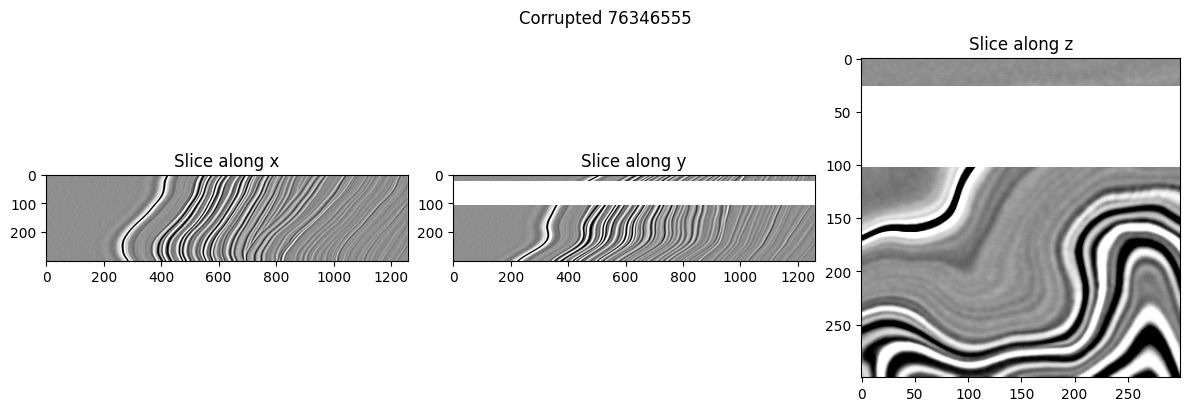

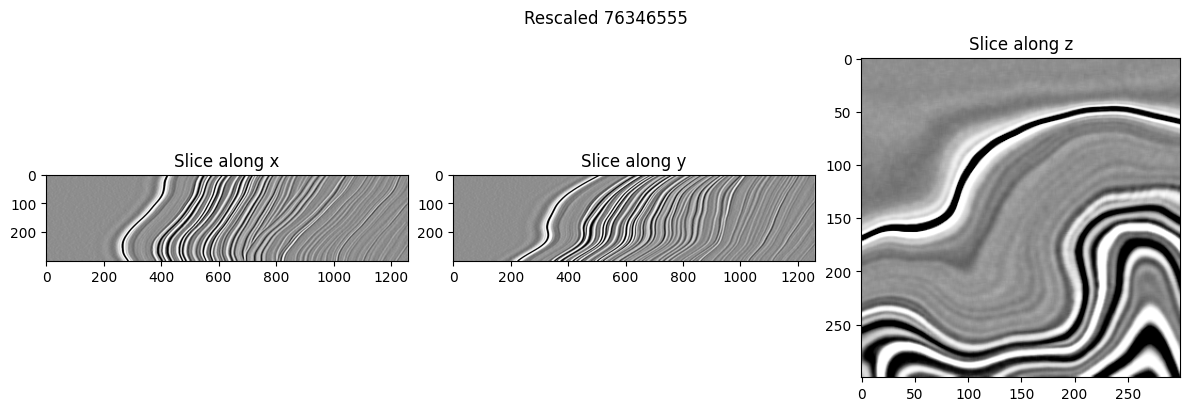

In [7]:
for img_file, target_file in zip(sorted(os.listdir(GEN_DATA_DIR))[:5], sorted(os.listdir(TARGET_DATA_DIR))[:5]):
    target = nib.load(TARGET_DATA_DIR / target_file)
    visualize_slices(target, 150, 150, 400, f'Original {img_file.split(".")[-2]}')
    img = nib.load(GEN_DATA_DIR / img_file)
    visualize_slices(img, 150, 150, 400, f'Corrupted {img_file.split(".")[-2]}')
    rescaled = rescale_volume(target.get_fdata())
    visualize_slices(nib.Nifti1Image(rescaled, np.eye(4)), 150, 150, 400, f'Rescaled {img_file.split(".")[-2]}')
    break

In [8]:
class Net(pl.LightningModule):
    
    def __init__(self):
        super().__init__()
        
        self._model = UNet(
            spatial_dims=3,
            in_channels=1,
            out_channels=1,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            num_res_units=2,
            norm=Norm.BATCH
        )
        
        self.loss_function = nn.MSELoss()
    
    def forward(self, x):
        return self._model(x)
    
    def prepare_data(self):
        images = sorted(os.listdir(GEN_DATA_DIR))
        targets = sorted(os.listdir(TARGET_DATA_DIR))
        
        assert images == targets
        train_dict = [
            {'image': GEN_DATA_DIR / image_name, 'target': TARGET_DATA_DIR / target_name} for image_name, target_name in zip(images[:20], targets[:20])
        ]
        
        val_dict = [
            {'image': GEN_DATA_DIR / image_name, 'target': TARGET_DATA_DIR / target_name} for image_name, target_name in zip(images[20:], targets[20:])
        ]
        
        train_transforms = Compose(
            # for now each image would be normalized based on its own mean and std
            [LoadImaged(keys=['image', 'target']),
             EnsureChannelFirstd(keys=['image', 'target']), 
             Orientationd(keys=["image", "target"], axcodes="RAS"),
             MaskTransform(keys=['image']),
             RescaleTransform(keys=['target']),
             # Problem: missing areas are nans, which causes everything else to be nan
             SignalFillEmptyd(keys=['image'], replacement=256),
             ReferenceBasedNormalizeIntensityd(keys=["image", "target"], ref_key='target'),
             RandSpatialCropd(keys=['image', 'target', 'mask'], 
                         roi_size=(256, 256, 256), random_size=False)
            ]
        )
        
        val_transforms = Compose(
            # for now each image would be normalized based on its own mean and std
            [LoadImaged(keys=['image', 'target']),
             EnsureChannelFirstd(keys=['image', 'target']), 
             Orientationd(keys=["image", "target"], axcodes="RAS"),
             RescaleTransform(keys=['target']),
             # Problem: missing areas are nans, which causes everything else to be nan
             SignalFillEmptyd(keys=['image'], replacement=256),
             ReferenceBasedNormalizeIntensityd(keys=["image", "target"], ref_key='target'),
             RandSpatialCropd(keys=['image', 'target'], 
                         roi_size=(256, 256, 256), random_size=False)
            ]
        )
        
        self.train_data = Dataset(
            data = train_dict, 
            transform = train_transforms
        )
        
        self.val_data = Dataset(
            data = val_dict, 
            transform = val_transforms
        )
        
    def train_dataloader(self):
        train_loader = DataLoader(
            self.train_data,
            batch_size=2,
            shuffle=True,
            num_workers=4, 
            collate_fn=list_data_collate
        )
        return train_loader
    
    def val_dataloader(self):
        val_loader = DataLoader(self.val_data, batch_size=1, num_workers=4)
        return val_loader
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self._model.parameters(), 1e-4)
        return optimizer
    
    def validation_step(self, batch, batch_idx):
        images, targets = batch["image"], batch["target"]
        output = self.forward(images)
        loss = self.loss_function(output, targets)
        self.log('val_loss', loss, prog_bar=True, sync_dist=True, on_epoch=True)
        return {"val_loss": loss}
    
    def training_step(self, batch, batch_idx):
        images, targets, mask = batch["image"], batch["target"], batch['mask']
        output = self.forward(images)
        loss = self.loss_function(output, targets)
        self.log('train_loss', loss, prog_bar=True, sync_dist=True, on_epoch=True)
        return {"loss": loss}
        

In [9]:
net = Net()

net.prepare_data()

In [10]:
dataiter = iter(net.train_data)

In [11]:
sample = next(dataiter)

In [12]:
sample.keys()

dict_keys(['image', 'target', 'mask', 'mean', 'std'])

Images are cropped because they can't fit into the memory

In [13]:
sample['image'].shape

torch.Size([1, 256, 256, 256])

In [14]:
original_pt = sample['target'].as_tensor()[0]
corrupted_pt = sample['image'].as_tensor()[0]

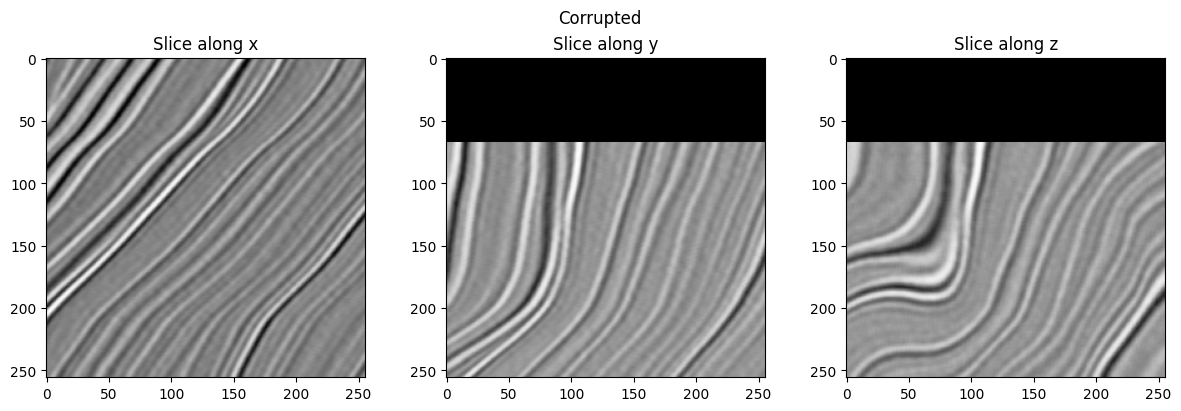

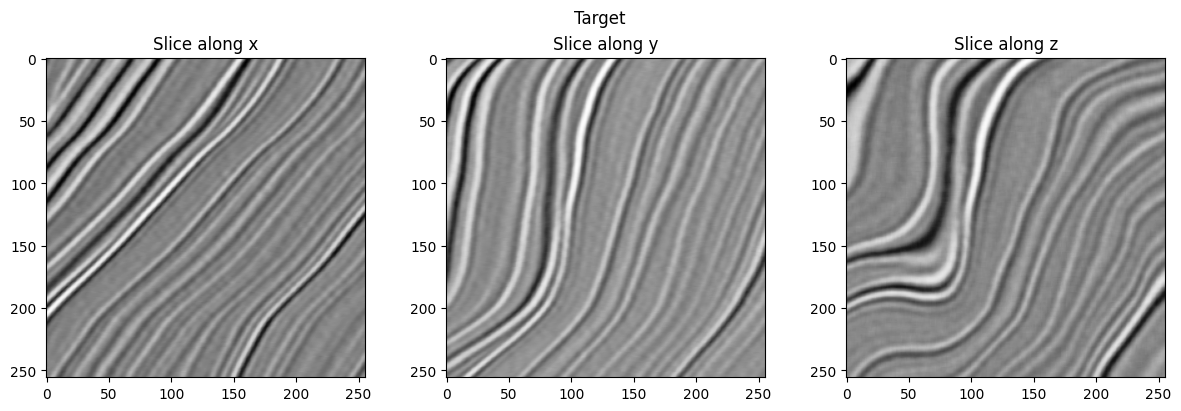

In [15]:
visualize_slices(nib.Nifti1Image(corrupted_pt.numpy(), np.eye(4)), 100, 100, 100, 'Corrupted')
visualize_slices(nib.Nifti1Image(original_pt.numpy(), np.eye(4)), 100, 100, 100, 'Target')

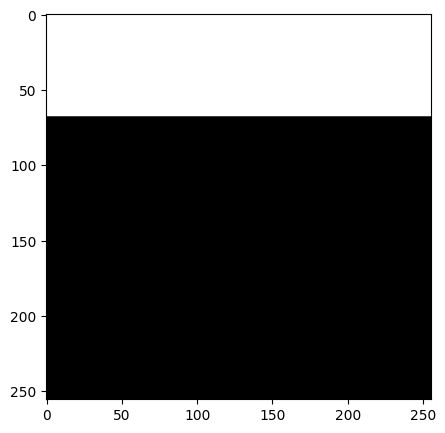

In [16]:
plt.figure(figsize=(5, 5))
plt.imshow(sample['mask'][0].numpy()[:, 100, :], cmap='gray')

In [17]:
corrupted_pt.numpy()[100, :, :]

array([[ 1.4809033 ,  1.2147627 ,  0.7945404 , ...,  0.4723701 ,
         0.71049595,  0.76652575],
       [ 1.3548366 ,  1.0326663 ,  0.61244434, ...,  0.640459  ,
         0.8505702 ,  0.8225551 ],
       [ 1.2147627 ,  0.87858486,  0.48637763, ...,  0.71049595,
         0.8505702 ,  0.7245035 ],
       ...,
       [ 0.02413308,  0.10817754,  0.09417001, ...,  0.36031094,
         0.05214778, -0.11594115],
       [ 0.02413308,  0.03814061, -0.04590385, ...,  0.09417001,
        -0.11594115, -0.19998543],
       [ 0.01012554, -0.04590385, -0.24200767, ..., -0.08792609,
        -0.18597808, -0.18597808]], dtype=float32)

In [18]:
original_pt.numpy()[100, :, :]

array([[ 1.4809033 ,  1.2147627 ,  0.7945404 , ...,  0.4723701 ,
         0.71049595,  0.76652575],
       [ 1.3548366 ,  1.0326663 ,  0.61244434, ...,  0.640459  ,
         0.8505702 ,  0.8225551 ],
       [ 1.2147627 ,  0.87858486,  0.48637763, ...,  0.71049595,
         0.8505702 ,  0.7245035 ],
       ...,
       [ 0.02413308,  0.10817718,  0.09417001, ...,  0.36031094,
         0.05214778, -0.11594115],
       [ 0.02413308,  0.03814061, -0.04590385, ...,  0.09417001,
        -0.11594115, -0.19998543],
       [ 0.01012554, -0.04590385, -0.24200767, ..., -0.08792609,
        -0.1859779 , -0.1859779 ]], dtype=float32)

In [19]:
F.mse_loss(corrupted_pt[100, :, :], original_pt[100, :, :])

tensor(1.1631e-14)

In [20]:
structural_similarity(corrupted_pt.numpy()[100, :, :], original_pt.numpy()[100, :, :], data_range=255)

1.0000000001935958

In [21]:
net = Net()
net.prepare_data()

dataloader = net.train_dataloader()

for i, batch in enumerate(dataloader):
    output = net(batch['image'])
    break

In [22]:
output

metatensor([[[[[ 2.5316e-01,  5.4672e-01,  2.8590e-01,  ...,  5.5780e-02,
             1.6938e-02, -8.8438e-02],
           [ 6.2816e-01,  1.8240e+00,  2.5058e-02,  ...,  6.7479e-01,
             1.6467e-01, -2.2804e-01],
           [-2.9922e-01,  3.9135e-01, -2.7849e-01,  ...,  7.7772e-02,
            -1.3767e-01, -2.8518e-01],
           ...,
           [ 5.6596e-02,  9.4085e-01,  1.5121e-02,  ...,  4.8785e-02,
             7.2947e-01,  1.1726e-01],
           [-4.7670e-01, -5.0846e-01, -7.8174e-02,  ...,  4.1505e-02,
             3.9809e-03, -2.8945e-01],
           [-7.8318e-02, -4.3047e-01,  1.6276e-01,  ...,  5.6897e-02,
             4.3862e-01,  1.8775e-01]],

          [[ 2.1031e-01,  1.4316e-01, -6.0860e-03,  ...,  7.9467e-02,
            -2.8672e-01,  2.7173e-01],
           [ 6.4842e-02, -5.7507e-01, -7.6501e-01,  ..., -4.5279e-01,
             1.6202e-01, -1.4853e-01],
           [ 8.1797e-02,  1.6949e+00, -1.6785e-01,  ...,  4.0851e-01,
            -3.6059e-01,  4.4270e-01

In [23]:
F.mse_loss(batch['target'], output)

metatensor(2.3666, grad_fn=<AliasBackward0>)

In [24]:
masked_target = batch['target'] * batch['mask']

In [25]:
masked_target.max()

metatensor(2.9195)

In [26]:
F.mse_loss(batch['target'], output)

metatensor(2.3666, grad_fn=<AliasBackward0>)

#### Problems
1. The whole volume can't fit into the memory
2. U-Net imposes constraints on the sizes of the volumes because of the down and up samplings

https://github.com/Project-MONAI/tutorials/blob/main/modules/UNet_input_size_constraints.ipynb

In [35]:
max_epochs = 20

checkpoint_dir = Path('/kaggle/working/unet-3')
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath=checkpoint_dir, filename='{epoch}-{val_loss:.2f}-{train_loss:.2f}', 
                                      monitor='val_loss', save_last=True) 
# early_stopping = pl.callbacks.EarlyStopping(monitor='val_loss', verbose=True)
 
net = Net()

trainer = pl.Trainer(
    max_epochs=max_epochs,
    default_root_dir=checkpoint_dir,
    callbacks=[checkpoint_callback],
    fast_dev_run=False
)

trainer.fit(net)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /kaggle/working/unet-3 exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [40]:
val_loader = net.val_dataloader()

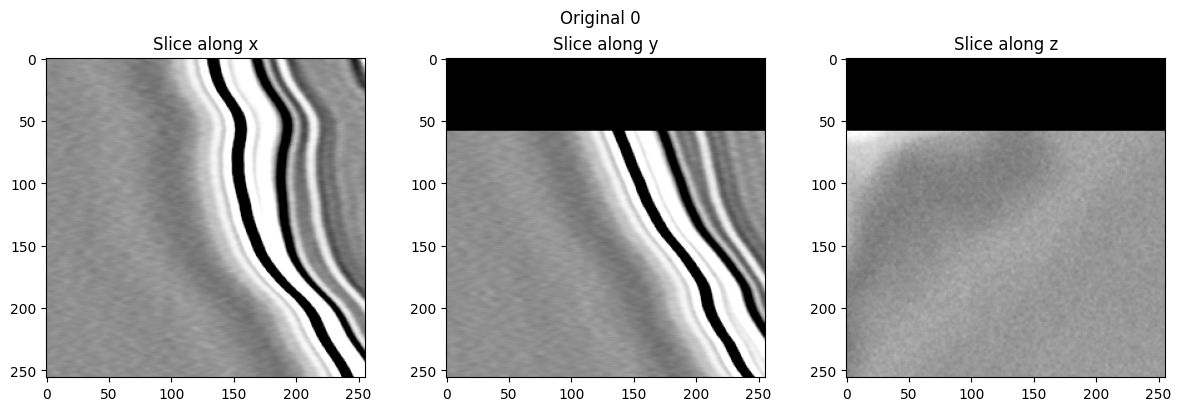

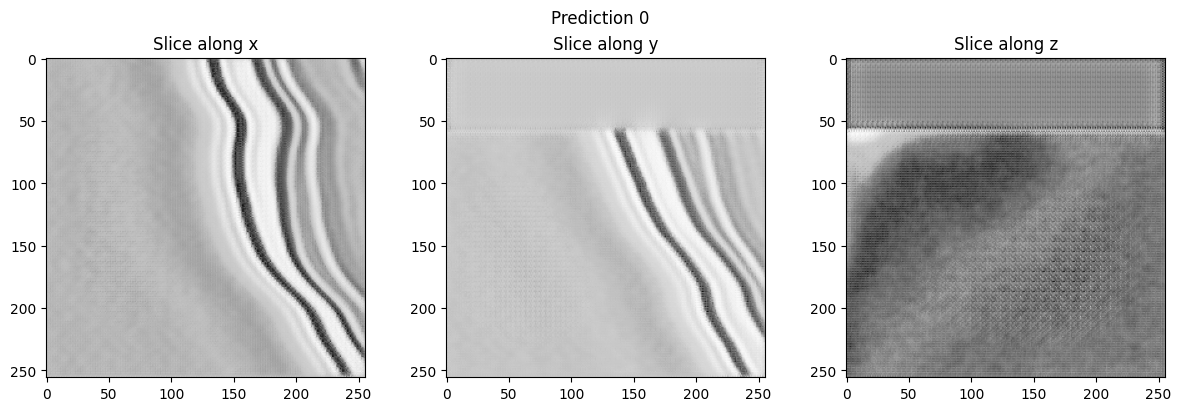

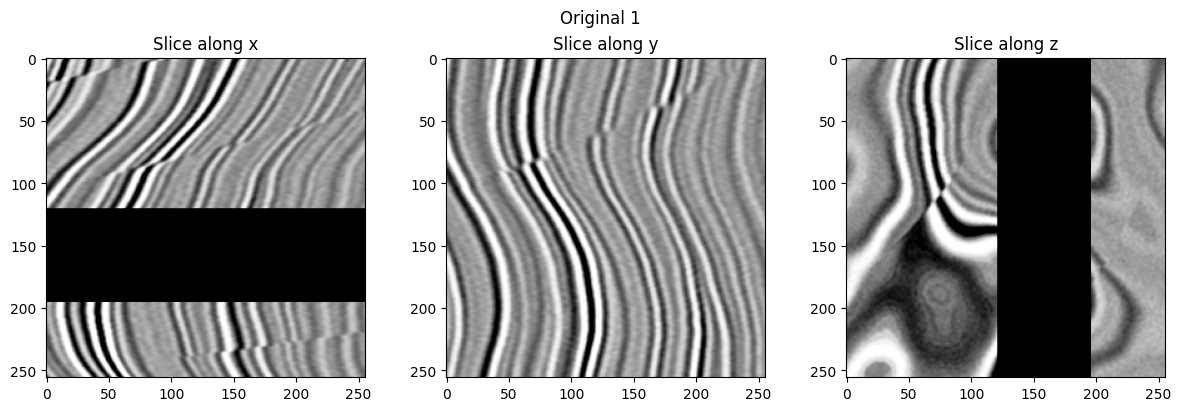

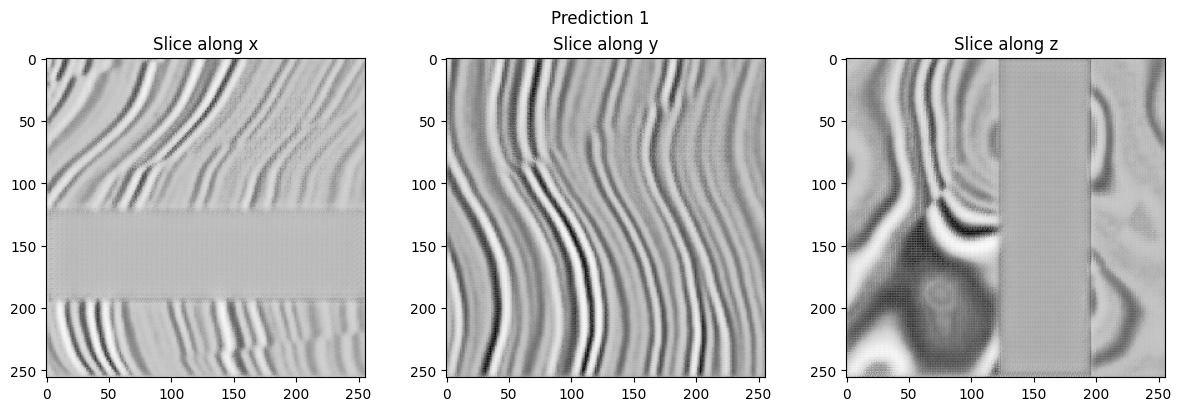

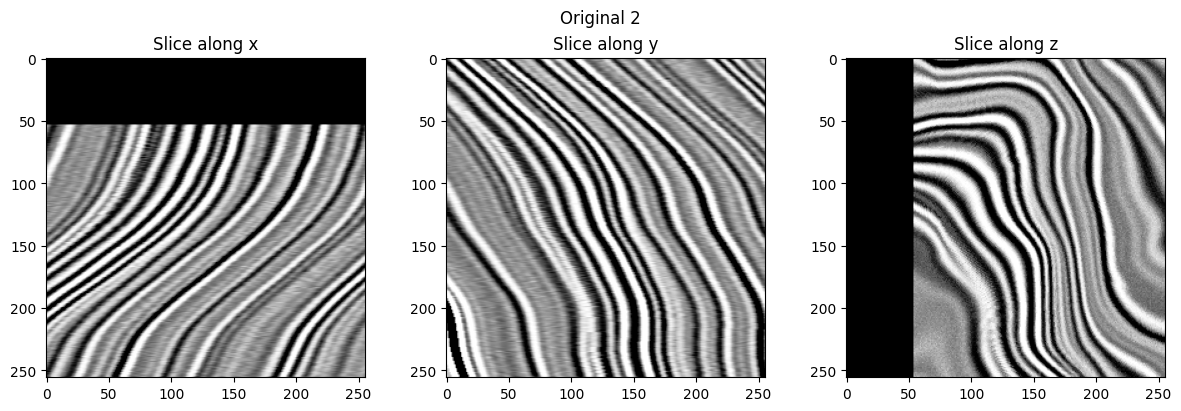

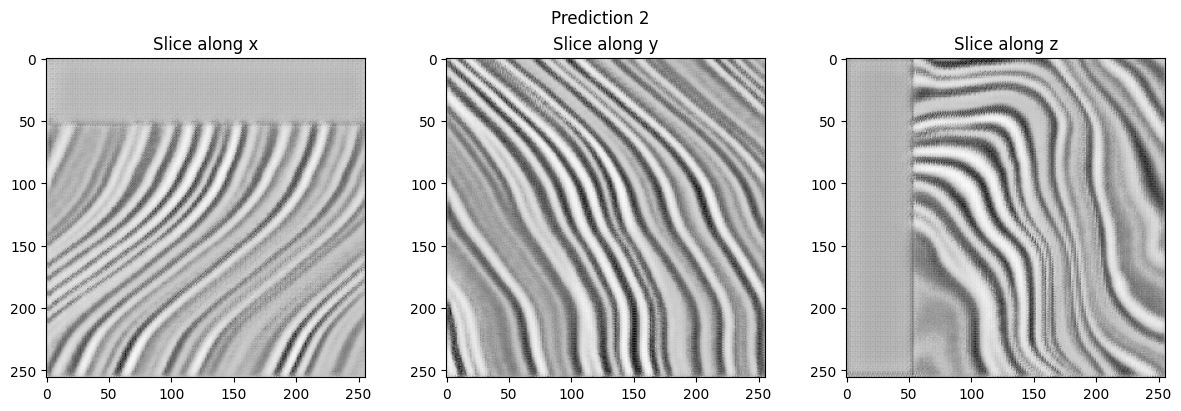

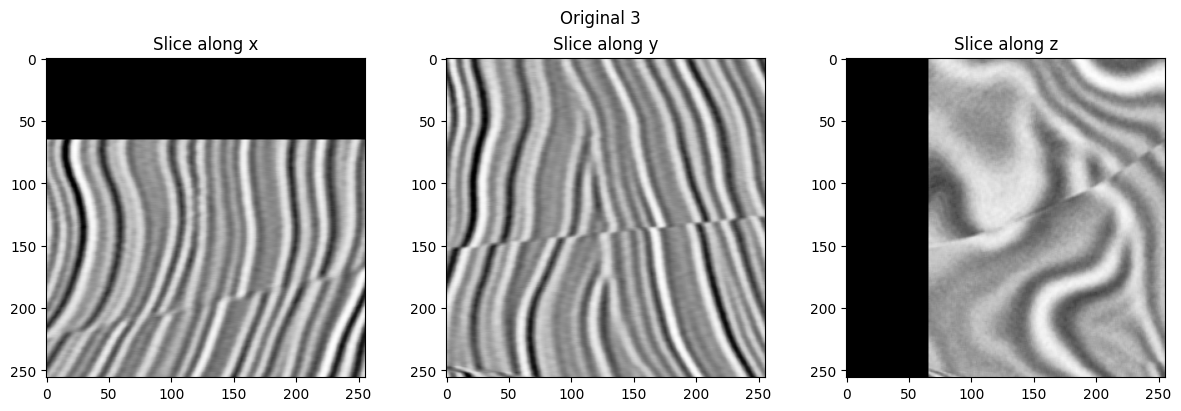

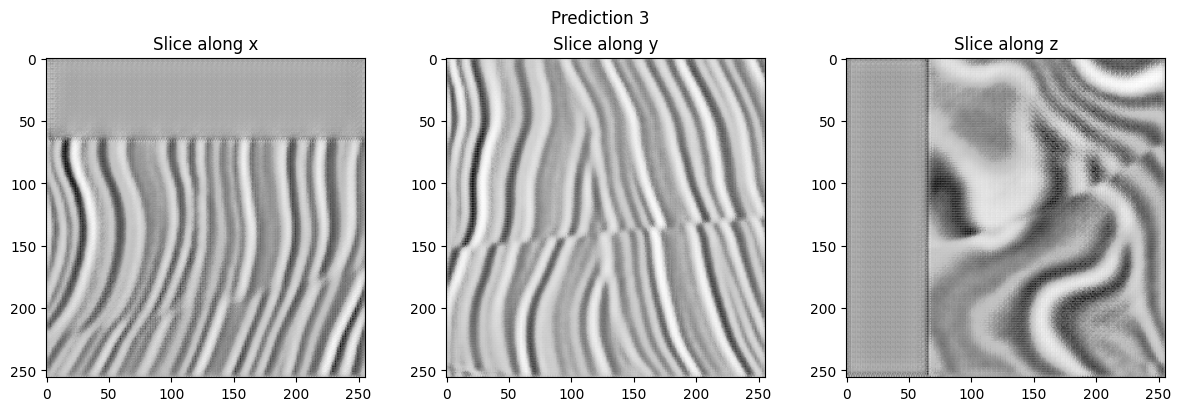

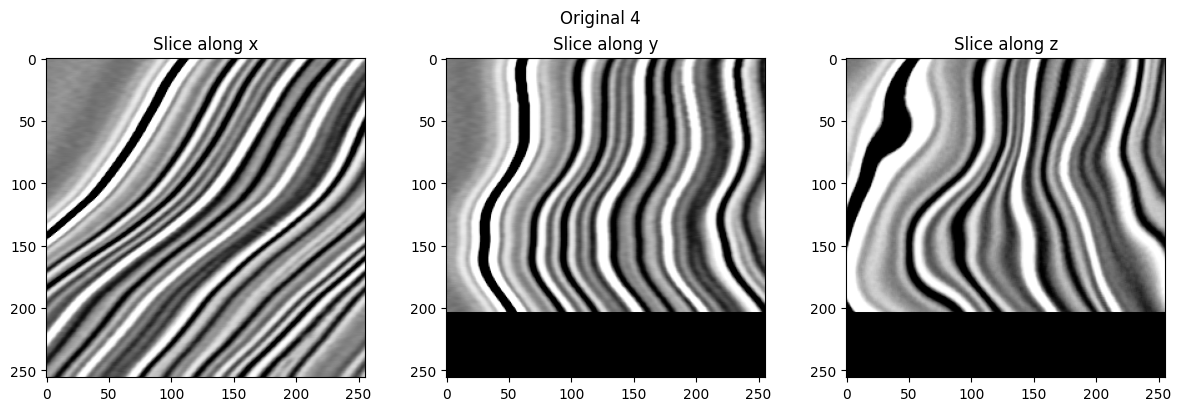

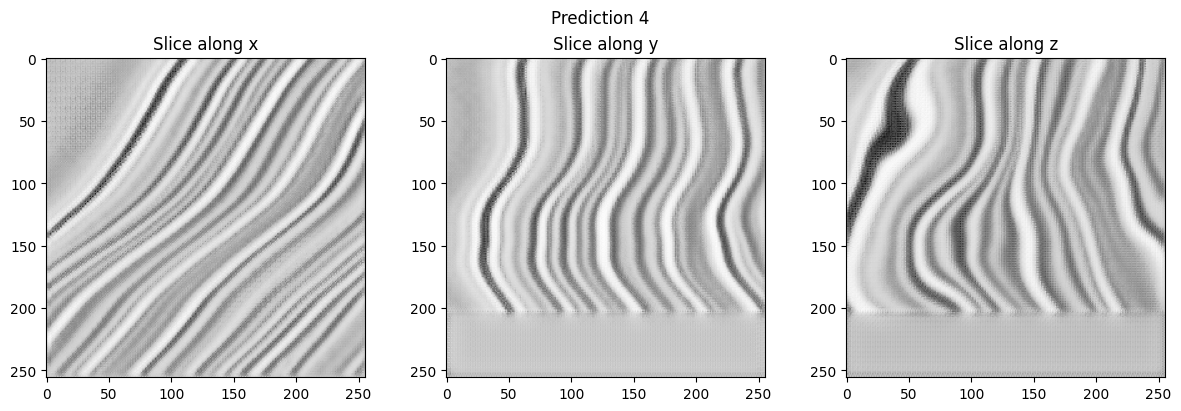

In [43]:
for i, batch in enumerate(val_loader):
    prediction = net(batch['image'])
    visualize_slices(nib.Nifti1Image(batch['image'].numpy()[0, 0, ...], np.eye(4)), 100, 100, 100, f'Original {i}')
    visualize_slices(nib.Nifti1Image(prediction.detach().numpy()[0, 0, ...], np.eye(4)), 100, 100, 100, f'Prediction {i}')